# Tutorial on Grover's Algorithm (1)
## Circuit with 4 qubits (and 1 output and 2 ancilla)
***

### The 2023 World Congress in Computer Science, Computer Engineering, & Applied Computing (CSCE'23)
### The 2nd International Conference on Emergent Quantum Technologies (ICEQT'23)

### July 24-27 2023 Las Vegas, NV
By Leon Deligiannidis, Ph.D.,
School of Computing and Data Science,
Wentworth Institute of Technology,
Boston, MA.
***

In [ ]:
!pip install qiskit[visualization]

In [1]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit.visualization import plot_histogram
print("Imports Successful")

Imports Successful


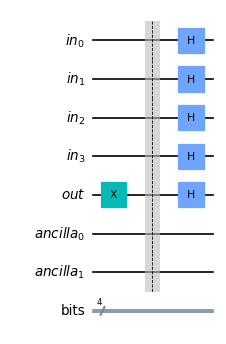

In [2]:
n_qbits = 4  # 4 qubits for input
scale = 0.6  # scale factor for drawing the circuits

q = QuantumRegister(n_qbits, name='in')            # Input register with 4 qubits
qout = QuantumRegister(1, name='out')              # Output register, 1 qubit     
ancilla = QuantumRegister(2, name='ancilla')       # Ancilla register with 2 qubits
c = ClassicalRegister(n_qbits, "bits")             # Classical register to read the result in, 4 bits

circuit= QuantumCircuit(q, qout, ancilla, c)       # Quantum circuit where we can attach quantum gates.

circuit.x(n_qbits)                                 # on qubit 4 attach an X gate (that's the Output register)
circuit.barrier()                                  # barrier, for cosmetics
circuit.h(q)                                       # Attach a Hadamard (H) gate on all qubits of the Input register
circuit.h(qout)                                    # Also attach a H gate on the Output register

circuit.draw('mpl', scale=scale)                   # Draw the circuit so far

The function below creates the circuit for the Oracle.
We pass it a binary string of size 4 (such as "0111"), and creates a circuit for it, utilizing 7 qubits.
<UL>
    <LI> 4 qubits for the input register "0111"</LI>
    <LI> 1 qubit for the output register</LI>
    <LI> 2 qubits for the ancilla qubits</LI>
</UL>

<img src=resources/TutPic1.PNG width=50%>

The Oracle flips the phase of the solution(s), leaves everything else unchanged.

In [3]:
def createOracle(s):
    o = QuantumCircuit(7, name='O\nR\nA\nC\nL\nE')
    o.barrier()
    
    #
    # For every zero, attach an X gate.
    #
    for i in range(4):
        if s[i] == 0:
            o.x(i)                  # X gate on qubit i
   
    o.barrier()
    o.ccx(0,1, 5)                   # X gate on qubit 5. Two controlls, qubits 0 and 1
    o.barrier()
    o.ccx(2,3, 6)
    o.barrier()
    o.ccx(5,6, 4)
    o.barrier()

    #
    # now uncompute! Leave ancilla qubits clear!
    #
    o.ccx(2,3, 6)
    o.barrier()
    o.ccx(0,1, 5)
    o.barrier()
    
    #
    # Undo the insertion of the X gate above.
    #
    for i in range(4):
        if s[i] == 0:
            o.x(i)   
            
    o.barrier()
    return o

Searching for string: [1 0 1 1].


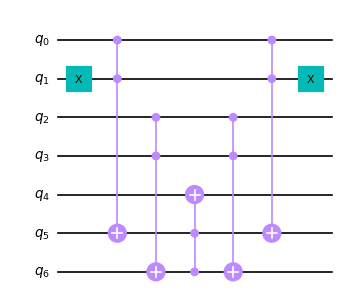

In [4]:
myString = np.random.randint(2, size=n_qbits)     # or provide your own: myString = [1,1,1,0]
print(f"Searching for string: {myString}.")

oracle = createOracle(myString)
oracle.draw('mpl', scale=scale, plot_barriers=False)

Create the circuit for the "Inversion about the Mean".<BR>
Note that we are not using the  Output register here. Only the Input register is used (4 qubits) and one ancilla qubit.
    <img src=resources/TutPic2.PNG width=50%>

In [5]:
def createInversionAboutTheMean():
    q = QuantumRegister(4, name='in')
    ancilla = QuantumRegister(1, name='ancilla')
    
    o = QuantumCircuit(q, ancilla, name='iam')
    o.barrier()
    o.h(q)
    o.barrier()
    o.x(q)
    o.barrier()
    
    o.barrier()
    o.h(3)
    o.barrier()
    o.ccx(0,1, 4)
    o.barrier()
    o.ccx(2,4, 3)
    o.barrier()
    o.ccx(0,1, 4)
    o.barrier()
    o.h(3)
    o.barrier()
    
    o.barrier()
    o.x(q)
    o.barrier()
    o.h(q)
    o.barrier()
    return o


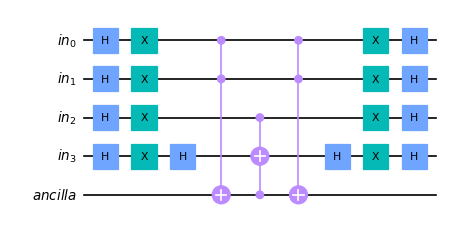

In [6]:
iam = createInversionAboutTheMean()
iam.decompose('iam').draw('mpl', scale=scale, plot_barriers=False)

One Iteration is running the Oracle and the "Invertion about the Mean" once.<BR>
    How many Iterations do we need here? Note that we are using 4 qubits as input, so:<P>
    Number_of_Iterations $= \frac{\pi}{4}\sqrt{4^2} = 3$

In [7]:
my_iters=int( (np.pi/4.0) * np.sqrt((2**n_qbits)) )
print(f"Number of iterations {my_iters}. Total elements in database: {2**n_qbits}")

for i in range(my_iters):
    circuit.append(oracle, list(range(0,7)))
    circuit.append(iam, list(range(0,4))+[5])    # attach it on qubits 0,1,2,3, 5 (skip 4 the output qubit)

circuit.measure(range(4), range(4))              # Attach measuring gates to read the result on classical bits.

Number of iterations 3. Total elements in database: 16


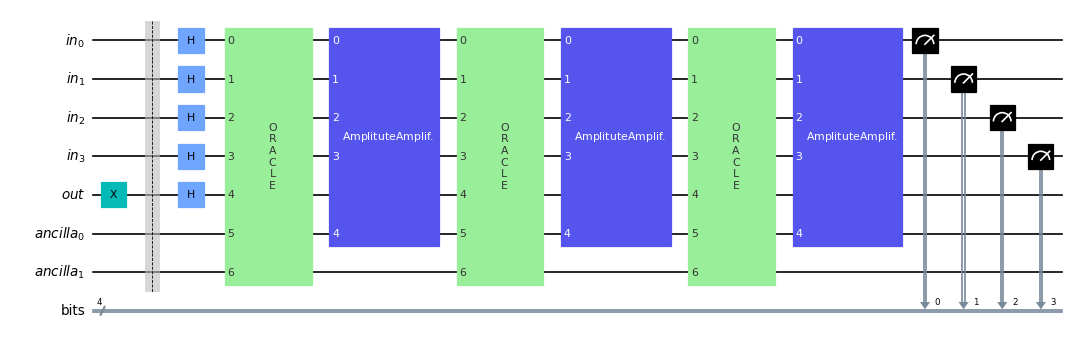

In [8]:
#
# Let's play with "styles", for fun.
#
style={'displaycolor': {  'iam':              ('#5555ee', '#ffffff'),
                          'O\nR\nA\nC\nL\nE': ('#99ee99', '#333333')    },
       'displaytext':  {'iam': "Amplitute Amplif."}}

circuit.draw('mpl', scale=scale, plot_barriers=True, style=style)

Let's draw the entire circuit with all its gate.

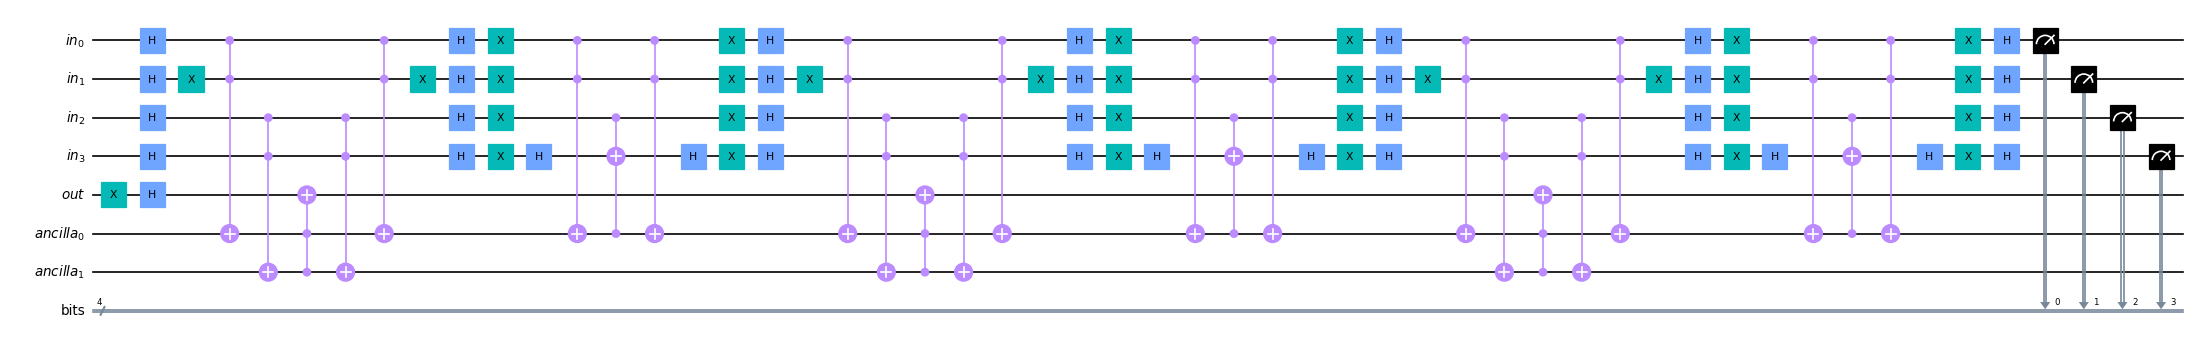

In [9]:
circuit.decompose('O\nR\nA\nC\nL\nE').decompose('iam').draw('mpl', scale=scale, plot_barriers=False, fold=60)

Let's run the circuit on a simulator for 1024 times, then use a histogram to see what we get.<BR>
Please note that the first bit specified, in qiskit is the least-significant-bit!

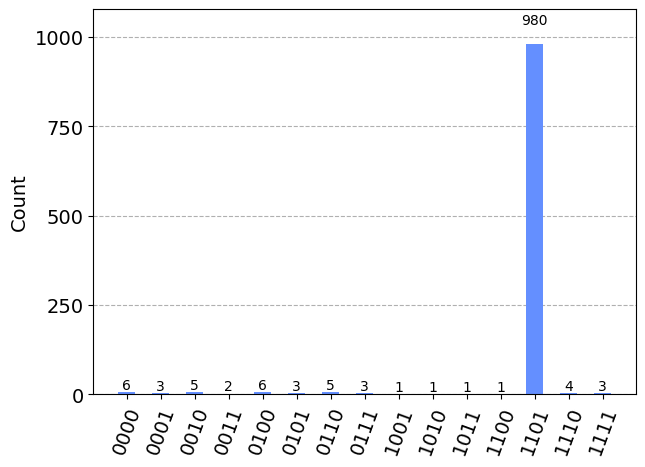

The answer is: {'1010': 1, '1101': 980, '0110': 5, '0011': 2, '0111': 3, '1011': 1, '0001': 3, '1111': 3, '0100': 6, '1110': 4, '1001': 1, '0101': 3, '0010': 5, '0000': 6, '1100': 1}


In [10]:
from qiskit import execute
simulator = Aer.get_backend('qasm_simulator')
job = execute(circuit, simulator, shots=1024)

result = job.result()
counts = result.get_counts(circuit)
display(plot_histogram(counts))
print(f"The answer is: {counts}")


In [11]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright